In [27]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib

In [ ]:
# Load and inspect dataset
data = pd.read_csv('../data/balanced_clean_data.csv')

In [29]:
# Assuming the last column is the target variable, split dataset into features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Standardisation des données pour améliorer la convergence des modèles réguliers
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log Reg

In [32]:
# Définir le modèle de régression logistique et les hyperparamètres pour GridSearchCV
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced')  # 'balanced' pour gérer les classes déséquilibrées
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga'], 'penalty': ['l1']},
    {'C': [0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'lbfgs', 'saga'], 'penalty': ['l2']}
]

In [33]:
# Set up GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2'],
                          'solver': ['liblinear', 'lbfgs', 'saga']}],
             scoring='roc_auc')

In [34]:
# Get the best model from grid search
best_log_reg = grid_search.best_estimator_
print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)


Best parameters from GridSearchCV:
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [35]:
# Sauvegarder le meilleur modèle
best_model_path = '../models/logreg_model.pkl'
joblib.dump(best_log_reg, best_model_path)

['../models/logreg_model.pkl']

In [36]:
# Make predictions and evaluate the model
y_pred = best_log_reg.predict(X_test)
y_prob = best_log_reg.predict_proba(X_test)[:, 1]

In [37]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Model Performance:
Accuracy: 0.71
Precision: 0.35
Recall: 0.75
ROC-AUC: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80     18300
           1       0.35      0.75      0.48      3778

    accuracy                           0.71     22078
   macro avg       0.64      0.73      0.64     22078
weighted avg       0.83      0.71      0.75     22078



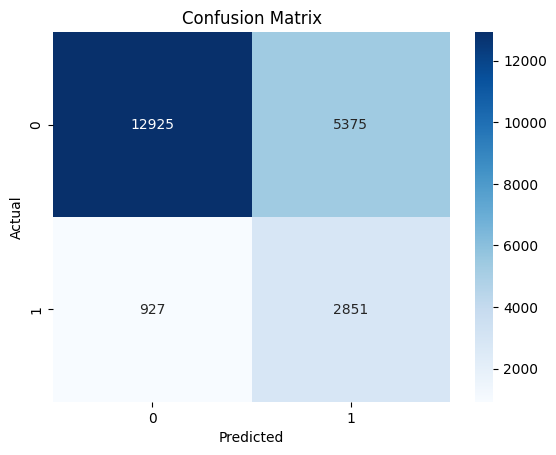

In [38]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

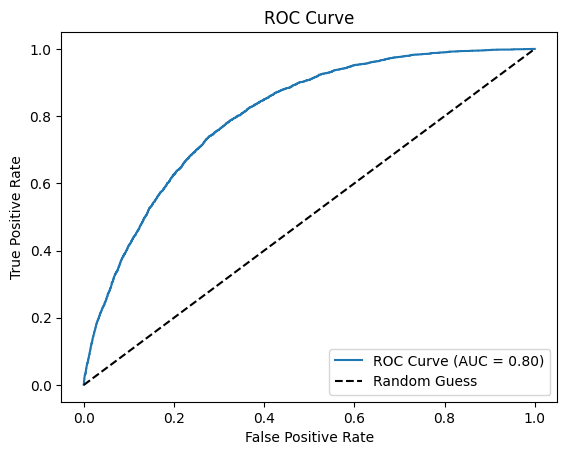

In [39]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

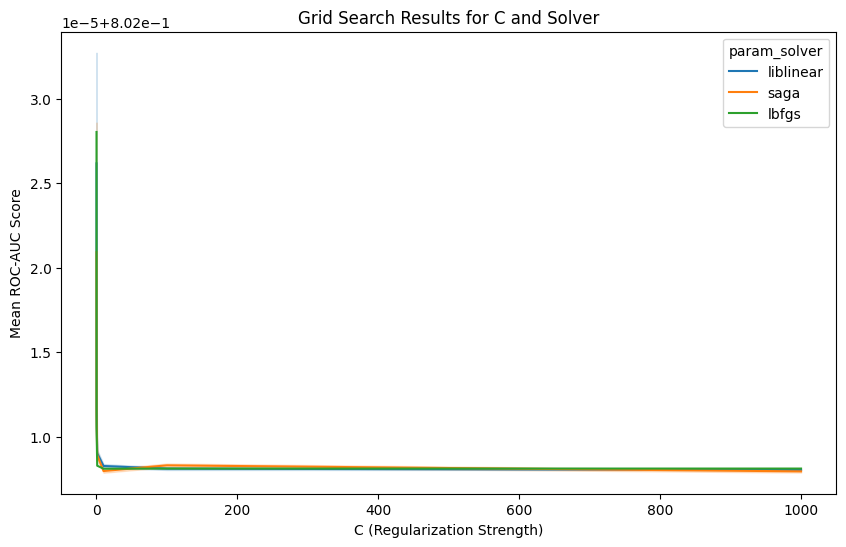

In [40]:
# 3. GridSearchCV results for parameter tuning
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_results, x='param_C', y='mean_test_score', hue='param_solver')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Mean ROC-AUC Score')
plt.title('Grid Search Results for C and Solver')
plt.show()

# DT

In [63]:
# Define the Decision Tree model and parameter grid for GridSearch
dt_classifier = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [64]:
# Set up GridSearchCV
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [65]:
# Get the best model from grid search
best_dt_classifier = grid_search.best_estimator_
print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)


Best parameters from GridSearchCV:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [66]:
# Sauvegarder le meilleur modèle
best_model_path = '../models/dt_model.pkl'
joblib.dump(best_dt_classifier, best_model_path)

['../models/dt_model.pkl']

In [67]:
# Make predictions and evaluate the model
y_pred = best_dt_classifier.predict(X_test)
y_prob = best_dt_classifier.predict_proba(X_test)[:, 1]

In [68]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.84
Precision: 0.58
Recall: 0.13
ROC-AUC: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     18300
           1       0.58      0.13      0.22      3778

    accuracy                           0.84     22078
   macro avg       0.71      0.56      0.56     22078
weighted avg       0.80      0.84      0.79     22078



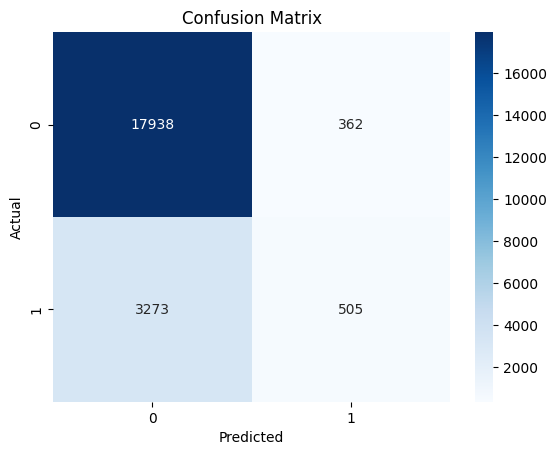

In [69]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

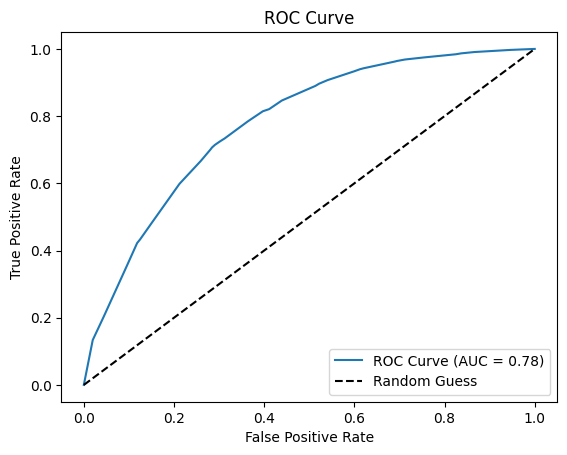

In [70]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

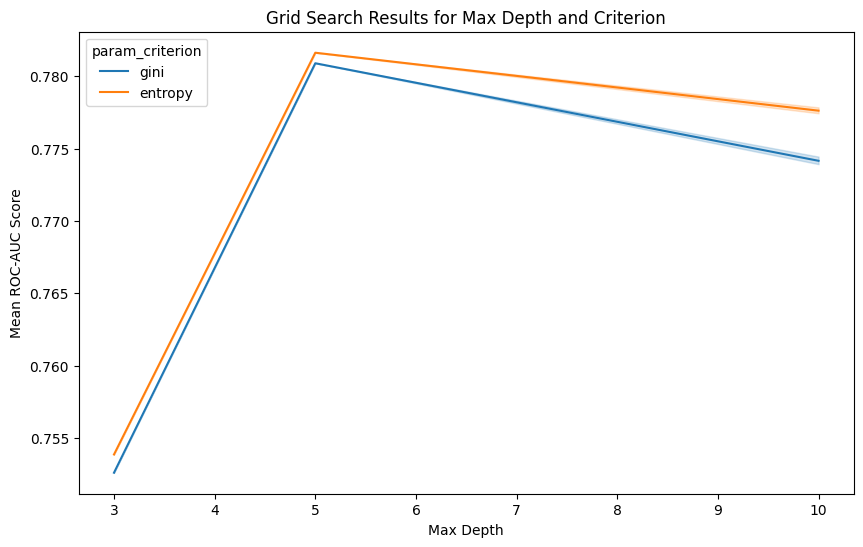

In [71]:
# 3. GridSearchCV results for parameter tuning
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_results, x='param_max_depth', y='mean_test_score', hue='param_criterion')
plt.xlabel('Max Depth')
plt.ylabel('Mean ROC-AUC Score')
plt.title('Grid Search Results for Max Depth and Criterion')
plt.show()

# RF

In [ ]:
# Define the Random Forest model and parameter grid for GridSearch
rf_classifier = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Get the best model from grid search
best_rf_classifier = grid_search.best_estimator_
print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)

In [ ]:
# Sauvegarder le meilleur modèle
best_model_path = '../models/rf_model.pkl'
joblib.dump(best_rf_classifier, best_model_path)

In [ ]:
# Make predictions and evaluate the model
y_pred = best_rf_classifier.predict(X_test)
y_prob = best_rf_classifier.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 3. GridSearchCV results for parameter tuning
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_results, x='param_n_estimators', y='mean_test_score', hue='param_criterion')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean ROC-AUC Score')
plt.title('Grid Search Results for Number of Estimators and Criterion')
plt.show()

# SVM

In [72]:
# Define the SVM model and parameter grid for GridSearch
svc = SVC(probability=True, random_state=42)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best model from grid search
best_svc = grid_search.best_estimator_
print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)

In [ ]:
# Sauvegarder le meilleur modèle
best_model_path = '../models/svc_model.pkl'
joblib.dump(best_svc, best_model_path)

In [ ]:
# Make predictions and evaluate the model
y_pred = best_svc.predict(X_test)
y_prob = best_svc.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 3. GridSearchCV results for parameter tuning
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_results, x='param_C', y='mean_test_score', hue='param_kernel')
plt.xlabel('Regularization Parameter C')
plt.ylabel('Mean ROC-AUC Score')
plt.title('Grid Search Results for C and Kernel')
plt.show()

# NV

In [ ]:
# Define the Naive Bayes model (GaussianNB) and parameter grid for GridSearch
nb_classifier = GaussianNB()
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 10)  # Smoothing parameter range for tuning
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best model from grid search
best_nb_classifier = grid_search.best_estimator_
print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)

In [ ]:
# Sauvegarder le meilleur modèle
best_model_path = '../models/nb_model.pkl'
joblib.dump(best_nb_classifier, best_model_path)

In [ ]:
# Make predictions and evaluate the model
y_pred = best_nb_classifier.predict(X_test)
y_prob = best_nb_classifier.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 3. GridSearchCV results for parameter tuning
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_results, x='param_var_smoothing', y='mean_test_score')
plt.xlabel('Variance Smoothing')
plt.ylabel('Mean ROC-AUC Score')
plt.title('Grid Search Results for Variance Smoothing')
plt.xscale('log')
plt.show()

# KNN

In [ ]:
# Define the KNN model and parameter grid for GridSearch
knn_classifier = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best model from grid search
best_knn_classifier = grid_search.best_estimator_
print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)

In [ ]:
# Sauvegarder le meilleur modèle
best_model_path = '../models/knn_model.pkl'
joblib.dump(best_knn_classifier, best_model_path)

In [ ]:
# Make predictions and evaluate the model
y_pred = best_knn_classifier.predict(X_test)
y_prob = best_knn_classifier.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 3. GridSearchCV results for parameter tuning
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_results, x='param_n_neighbors', y='mean_test_score', hue='param_weights')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean ROC-AUC Score')
plt.title('Grid Search Results for Number of Neighbors and Weights')
plt.show()

# xgboost

In [20]:
# Define the XGBoost model and parameter grid for GridSearch
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [21]:
# Set up GridSearchCV
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Get the best model from grid search
best_xgb_classifier = grid_search.best_estimator_
print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)


Best parameters from GridSearchCV:
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
# Sauvegarder le meilleur modèle
best_model_path = '../models/xgb_model.pkl'
joblib.dump(best_xgb_classifier, best_model_path)

['../models/xgb_model.pkl']

In [ ]:
# Make predictions and evaluate the model
y_pred = best_xgb_classifier.predict(X_test)
y_prob = best_xgb_classifier.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.84
Precision: 0.58
Recall: 0.18
ROC-AUC: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     18300
           1       0.58      0.18      0.27      3778

    accuracy                           0.84     22078
   macro avg       0.71      0.58      0.59     22078
weighted avg       0.80      0.84      0.80     22078



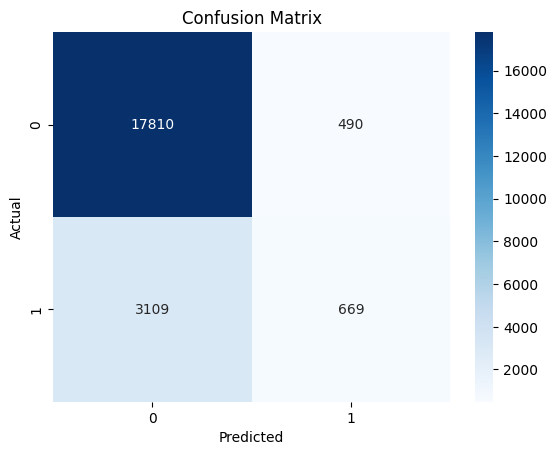

In [ ]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

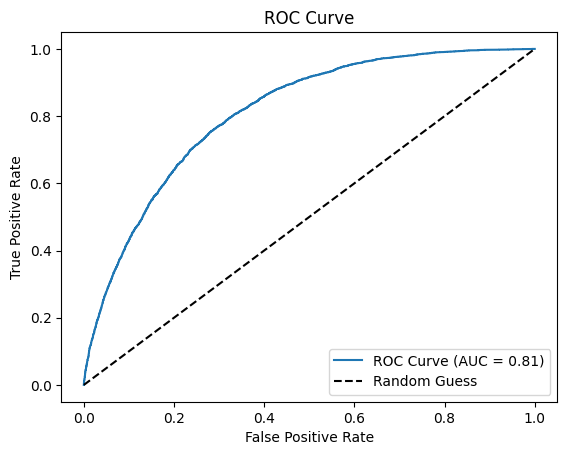

In [ ]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

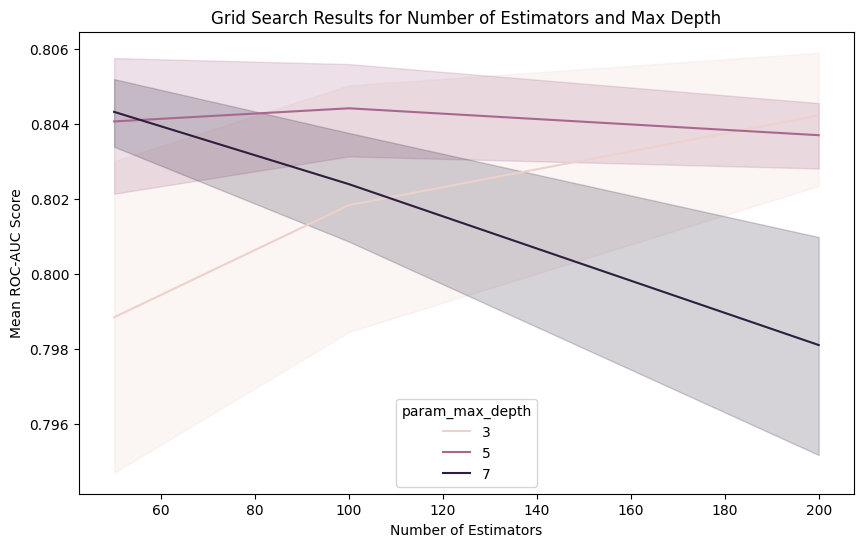

In [ ]:
# 3. GridSearchCV results for parameter tuning
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_results, x='param_n_estimators', y='mean_test_score', hue='param_max_depth')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean ROC-AUC Score')
plt.title('Grid Search Results for Number of Estimators and Max Depth')
plt.show()

# tensorflow

In [41]:
# Define a simple deep learning model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [42]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [43]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8284 - loss: 0.5462 - val_accuracy: 0.8291 - val_loss: 0.4508
Epoch 2/50
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8305 - loss: 0.4566 - val_accuracy: 0.8290 - val_loss: 0.4353
Epoch 3/50
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8293 - loss: 0.4388 - val_accuracy: 0.8294 - val_loss: 0.4247
Epoch 4/50
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8311 - loss: 0.4276 - val_accuracy: 0.8309 - val_loss: 0.4173
Epoch 5/50
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8341 - loss: 0.4181 - val_accuracy: 0.8333 - val_loss: 0.4109
Epoch 6/50
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8314 - loss: 0.4148 - val_accuracy: 0.8341 - val_loss: 0.4055
Epoch 7/50
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8328 - loss: 0.4070 - val_accuracy: 0.8350 - val_loss: 0.4011
Epoch 8/50
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8327 - loss: 0.4032 - 

In [44]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8369 - loss: 0.3722
Test Loss: 0.3681773841381073, Test Accuracy: 0.8372135162353516


In [45]:
# Save the entire model
model.save('../models/tfmodel.keras')